Lesson 9 Multi-label classification


The terms 'anchor boxes' and 'bounding boxes' were confusing at first, if talk about 'boxes' which ones are referred to? (Using 'anchor cells' instead of 'anchor boxes' would help).


    


In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

from fastai.conv_learner import *
from fastai.dataset import *

In [3]:
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True

In [4]:
PATH = Path('/mnt/samsung_1tb/Data/fastai/pascal/pascal_direct')
trn_j = json.load((PATH/'pascal_train2007.json').open())
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']
FILE_NAME, ID, IMG_ID, CAT_ID, BBOX = 'file_name','id','image_id','category_id','bbox'


In [5]:

#images: is list of {file_name, height, width, id}
#annotations:[{"segmentation":[[155,96,155,270,351,270,351,96]],"area":34104,"iscrowd":0,"image_id":12,"bbox":[155,96,196,174],"category_id":7,"id":1,"ignore":0}
#categories:[{"supercategory":"none","id":1,"name":"aeroplane"}
cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
#supercatgories in json file are all None
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [6]:
#note slightly different file setup to fastai path (train instead of VOCdevkit
JPEGS = 'train/VOC2007/JPEGImages'
IMG_PATH = PATH/JPEGS

In [7]:
#reuse functions from pascal, addmitedly I just copied and pasted these functions from the pascal_multi.ipynb
def get_trn_anno():
    trn_anno = collections.defaultdict(lambda:[])
    for o in trn_j[ANNOTATIONS]:
        if not o['ignore']:
            bb = o[BBOX]
            bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
            trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
    return trn_anno

trn_anno = get_trn_anno()

In [8]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [9]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    draw_im(im, im_a)

### Multi class classification

In [10]:
MC_CSV = PATH/'tmp/mc.csv'

In [11]:
#get image id 12 from this dict -returns bbox and category id
trn_anno[12]

[(array([ 96, 155, 269, 350]), 7)]

In [12]:
cats[7]

'car'

In [13]:
#for each image we dont want to repeat same labels
mc = [set([cats[p[1]] for p in trn_anno[o]]) for o in trn_ids]
#change from list to space sep string
mcs = [' '.join(str(p) for p in o) for o in mc]

In [14]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'clas': mcs}, columns=['fn', 'clas'])
df.to_csv(MC_CSV, index=False)
df.head(n=2)

fn          clas
0  000012.jpg           car
1  000017.jpg  horse person

In [15]:

f_model = resnet34
sz = 224
bs = 64

In [16]:
tfms = tfms_from_model(f_model, sz, crop_type= CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, MC_CSV, bs, tfms=tfms)

In [17]:
md.classes


['aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

data: training data for model, models: model architectures to base learner

NB we need to use ConvLearner.pretrained rater than ConvLearner as f_model is not populated

where pretrained calls ConvnetBuilder to build a model with self.model = to_gpu(nn.Sequential(*(layers+fc_layers)))

In [18]:

learn = ConvLearner.pretrained(f=f_model, data=md)
type(learn)

fastai.conv_learner.ConvLearner

In [19]:
learn.opt_fn = optim.Adam

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>   
    0      1.018527   10.567177  0.616677  



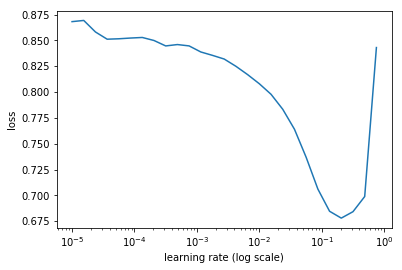

In [20]:
#loss depends on optimizer, ensure Adam is set above
learn.lr_find()
learn.sched.plot(0)

In [21]:
lr = 2e-2

In [22]:
learn.fit(lr, n_cycle=1, cycle_len=3, use_clr=(32,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>   
    0      0.326944   0.14156    0.952689  
    1      0.174721   0.077463   0.975045  
    2      0.116695   0.075393   0.975608  



[0.07539256, 0.9756084755063057]

In [23]:
lrs = np.array([lr/100, lr/10, lr])

In [24]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 81%|████████▏ | 26/32 [00:03<00:00,  6.53it/s, loss=0.277]


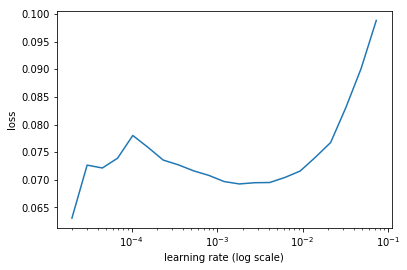

In [25]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [26]:
learn.fit(lrs/10, n_cycle=1, cycle_len=3, use_clr=(32,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>   
    0      0.081662   0.074521   0.975165  
    1      0.056622   0.074909   0.974872  
    2      0.039057   0.071985   0.975819  



[0.071985364, 0.9758188128471375]

In [27]:
learn.save('mclas')


In [28]:
learn.load('mclas')

In [29]:
preds = learn.predict()
preds

array([[0.00001, 0.99946, 0.00024, ..., 0.00003, 0.00004, 0.00011],
       [0.00014, 0.00131, 0.00027, ..., 0.74773, 0.00082, 0.00833],
       [0.00001, 0.     , 0.99944, ..., 0.00003, 0.     , 0.00004],
       ...,
       [0.0129 , 0.00358, 0.00035, ..., 0.00177, 0.00085, 0.00023],
       [0.00001, 0.00452, 0.00045, ..., 0.00022, 0.00003, 0.00001],
       [0.00001, 0.00039, 0.00049, ..., 0.00564, 0.00019, 0.00033]], dtype=float32)

In [30]:
x,_ = next(iter(md.val_dl))
x = to_np(x)

ya: [ 1 14]
ya: [11 17]
ya: [2]
ya: [14]
ya: [14]
ya: [6]
ya: [13]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ya: [ 8 10]
ya: [2]
ya: [9]
ya: [15]
ya: [6]


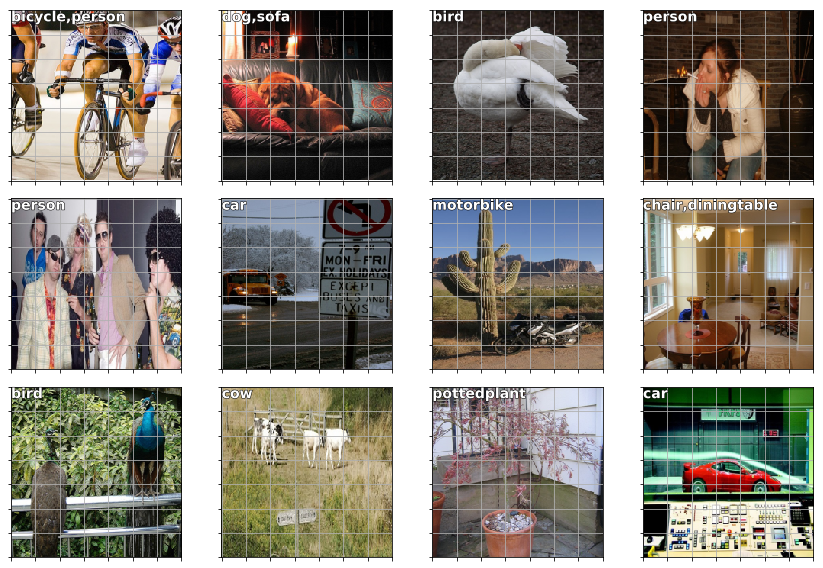

In [31]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ima = md.val_ds.denorm(x)[i]
    #Return the indices of the elements that are non-zero.
    ya = np.nonzero(preds[i]>0.4)[0]
    print(f'ya: {ya}')
    b = ','.join(md.classes[o] for o in ya)
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

## Box per cell


In [32]:
#set up csv files
CLAS_CSV = PATH/'tmp/clas.csv'
MBB_CSV = PATH/'tmp/mbb.csv'

In [33]:
f_model = resnet34
sz = 224
bs = 64

#### timdavidlee notes:

Create Lookups and reference objects

mc - list of items found per image

mcs - list of items found per image, but the ID

id2cat - numeric value to category

cat2id - category to id

In [34]:
mc = [[cats[p[1]] for p in trn_anno[o]] for o in trn_ids]
id2cat = list(cats.values())
cat2id = {v:k for k, v in enumerate(id2cat)}
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc])
mcs

array([array([6]), array([14, 12]), array([ 1,  1, 14, 14, 14]), ..., array([17,  8, 14, 14, 14]),
       array([6]), array([11])], dtype=object)

In [35]:
val_idxs = get_cv_idxs(len(trn_fns))
((val_mcs, trn_mcs),) = split_by_idx(val_idxs, mcs)

In [36]:
mbb = [np.concatenate([p[0] for p in trn_anno[o]]) for o in trn_ids]
mbbs = [' '.join(str(p) for p in o) for o in mbb]

In [37]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': mbbs}, columns=['fn', 'bbox'])
df.to_csv(MBB_CSV, index=False)
df.head(n=2)

fn                          bbox
0  000012.jpg                96 155 269 350
1  000017.jpg  61 184 198 278 77 89 335 402

In [38]:
#augmentations
aug_tfms = [RandomRotate(10, tfm_y = TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD)]

In [39]:
tfms = tfms_from_model(f_model, sz, aug_tfms=aug_tfms, tfm_y=TfmType.COORD, crop_type=CropType.NO)
#regression for coords
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, bs, tfms=tfms, continuous=True)

In [40]:
def get_cmap(num_colr):
    colr_norm = mcolors.Normalize(vmin=0, vmax=num_colr-1)
    #The ScalarMappable makes use of data normalization before returning
    #RGBA colors from the given colormap.
    rgb_map = cmx.ScalarMappable(norm=colr_norm, cmap='Set3').to_rgba
    return rgb_map

In [41]:
num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [42]:
def show_ground_truth(ax, im, bbox, clas=None, prs= None, thresh=0.3):
    #TODO lookup reshape, replace prs with more descriptive name
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:
        prs = [None]*len(bb)
    if clas is None:
        clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i, (b, c, pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None:
                txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None:
                txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [43]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds, self.y2 = ds, y2
        self.sz = ds.sz
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y, self.y2[i]))

In [44]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [45]:
x, y = to_np(next(iter(md.val_dl)))
#TODO trace .ds - why doe we need dataset.ds?
x = md.val_ds.ds.denorm(x)

In [46]:
x_trn, y_trn = to_np(next(iter(md.trn_dl)))
x_trn = md.trn_ds.ds.denorm(x_trn)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


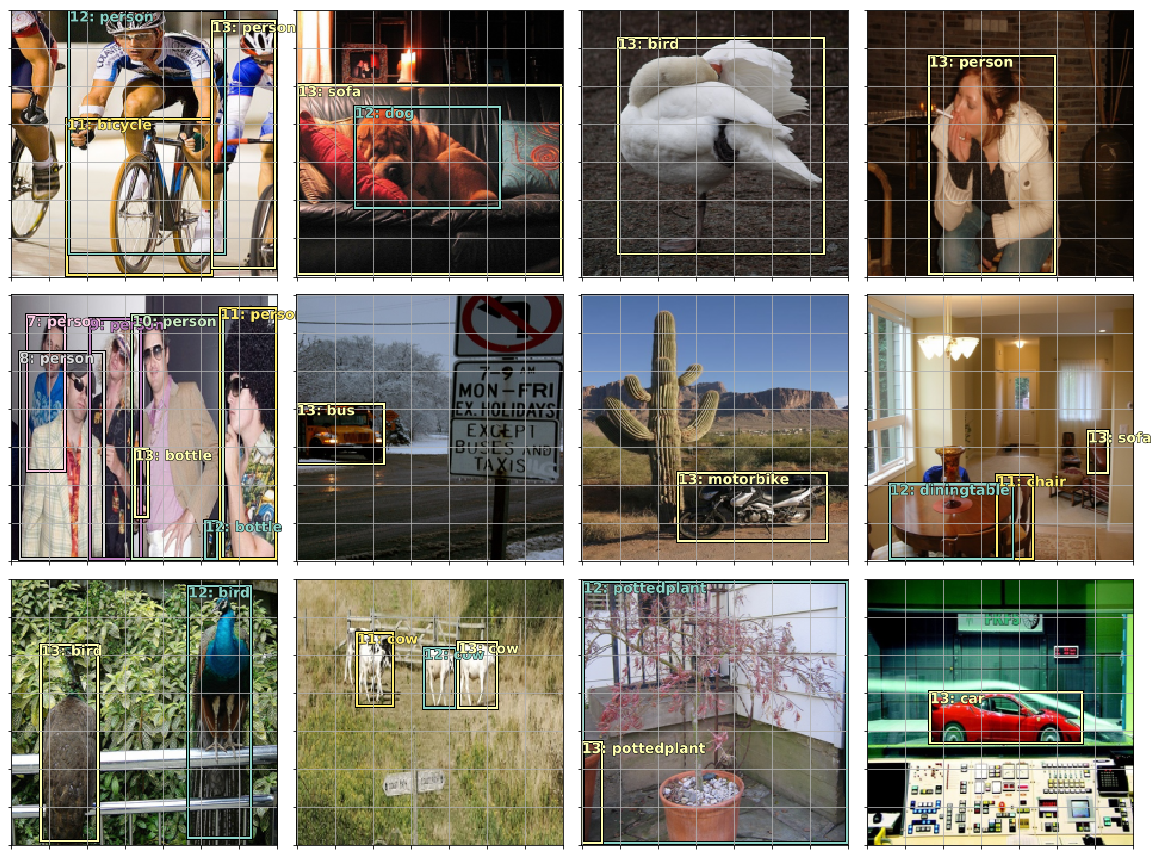

In [47]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

## Set up model
#### notes from timdavidlee

Make a model to predict what shows up in a 2x2 grid

anc_grid = how big of a square grid to make (subdivision)

anc_offset = center offsets

anc_x = x coordinates for centers

anc_y = y coordinates for centers

anc_ctrs - the actual coordinates for the grid centers

anc_sizes - size of the quadrants


In [48]:
anc_grid =4
k = 1 #scalar for out_channels, activations

In [49]:
anc_offset = 1/(anc_grid*2)
#linspace: Return evenly spaced numbers over a specified interval.
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
#tile(A, reps):Construct an array by repeating A the number of times given by reps.
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

In [50]:
anc_ctrs = np.tile(np.stack([anc_x, anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid, 1/anc_grid] for i in range(anc_grid*anc_grid)])
#requires_grad: Boolean indicating whether the Variable has been created by a subgraph containing any Variable, that requires it.
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

In [51]:
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

(0, 1)

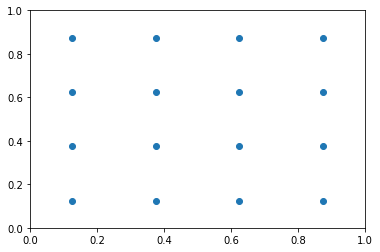

In [52]:
plt.scatter(anc_x, anc_y)
plt.xlim(0,1)
plt.ylim(0,1)

In [53]:
anchors[0]

Variable containing:
 0.1250
 0.1250
 0.2500
 0.2500
[torch.cuda.FloatTensor of size 4 (GPU 0)]

In [54]:
def hw2corners(ctr, hw):
    #cat: Concatenates the given sequence of :attr:`seq` tensors in the given dimension.
    return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [55]:
anchor_cnr = hw2corners(anchors[:,:2], anchors[:, 2:])
anchor_cnr

Variable containing:
 0.0000  0.0000  0.2500  0.2500
 0.0000  0.2500  0.2500  0.5000
 0.0000  0.5000  0.2500  0.7500
 0.0000  0.7500  0.2500  1.0000
 0.2500  0.0000  0.5000  0.2500
 0.2500  0.2500  0.5000  0.5000
 0.2500  0.5000  0.5000  0.7500
 0.2500  0.7500  0.5000  1.0000
 0.5000  0.0000  0.7500  0.2500
 0.5000  0.2500  0.7500  0.5000
 0.5000  0.5000  0.7500  0.7500
 0.5000  0.7500  0.7500  1.0000
 0.7500  0.0000  1.0000  0.2500
 0.7500  0.2500  1.0000  0.5000
 0.7500  0.5000  1.0000  0.7500
 0.7500  0.7500  1.0000  1.0000
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

In [56]:
#number of classes including background
n_clas = len(id2cat)+1
#act is an abbreviation for activations?
n_act = k*(4+n_clas)

### Single Shot Multibox Detector

#### StdConv() 

Default stride = 2

conv -> relu-> batchnorm -> dropout

In [57]:
class StdConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2, drop=0.1):
        super().__init__()
        #note we are using a 2d conv unlike prev where we replaced head with a 1d flattened conv
        #Conv2D args:
        #   in_channels (int): Number of channels in the input image
        #   out_channels (int): Number of channels produced by the convolution
        #   kernel_size (int or tuple): Size of the convolving kernel
        #   stride (int or tuple, optional): Stride of the convolution. Default: 1
        #   padding (int or tuple, optional): Zero-padding added to both sides of the input. Default: 0
        #   dilation (int or tuple, optional): Spacing between kernel elements. Default: 1
        #   groups (int, optional): Number of blocked connections from input channels to output channels. Default: 1
        #   bias (bool, optional): If ``True``, adds a learnable bias to the output. Default: ``True``
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        #The mean and standard-deviation are calculated per-dimension over the mini-batches
        self.bn = nn.BatchNorm2d(out_channels)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x):
        
        data = F.relu(self.conv(x))
        data = self.bn(data)
        data = self.drop(data)
        return data

In [58]:
def flatten_conv(x,k):
    #batch size, layers, x, y
    bs, nf, gx, gy = x.size()
    #Permute the dimensions of this tensor to given params
    x = x.permute(0,2,3,1).contiguous()
    #view reshapes the tensor, -1 for where don't know number and its automatically computed
    #// is integer division operator
    return x.view(bs, -1, nf//k)

#### OutConv() 

2 separate conv layers, each of which uses stride =1

One is length of num classes + background

the other (oconv2) is equal to 4

conv->flatten->convv->flatten

We could have done this using a single layer outputting 4+C, but using 2 separate sets of activations allows the layers to specialise a bit.

In [59]:
class OutConv(nn.Module):
    #stride default is 1
    def __init__(self, k, in_channels, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(in_channels, out_channels=(len(id2cat)+1)*k, kernel_size=3, padding=1)
        self.oconv2 = nn.Conv2d(in_channels, out_channels=4*k, kernel_size=3, padding=1)
        #bias Parameter
        self.oconv1.bias.data.zero_().add_(bias)
    
    def forward(self, x):
        #instead of having one output 4+C we output these separtely
        #2 sets of activations returned, one for bbox, one for classes
        #flatten is not necc, just cos other code needs that format
        data1 = flatten_conv(self.oconv1(x), self.k)
        data2 = flatten_conv(self.oconv2(x), self.k)
        return [data1, data2]


### SSD Workflow

Start with stride =1 convolution (StdConv) - this doesn't change geometry. This is not just a linear layer, but a mini Neural Net.

then we run StdConv with stride =2

then OutConv which consists of 2 separate conv. layers each of stride 1, but different lengths: 1 equivalent to number of classes; one equal to 4.




#### [Relu -> Dropout] -> [StdConv() stride=1] -> [StdConv() stride=2] -> [OutConv()]
#### [in: Final ResNet conv output] -> [in: 512, out: 256] -> [in: 256, out: 256] -> [in: 256, out: [C+1, 4]]


Note we are taking ResNet, which has a 7 x 7 x 512 final conv layer, and adding a custom head defined above:

ie in ConvnetBuilder the model becomes: to_gpu(nn.Sequential(*(layers+[custom_head])))

see ResNet summary: https://wiseodd.github.io/techblog/2016/10/13/residual-net/

The orginal Liu et al. (2016) SSD paper uses VGG-16 as the base network (through conv5_3 layer, the last conv layer)

see Fig.1 in Liu et al (2016) "*SSD framework. (a) SSD only needs an input image and ground truth boxes for
each object during training. In a convolutional fashion, we evaluate a small set (e.g. 4)
of default boxes of different aspect ratios at each location in several feature maps with
different scales (e.g. 8 × 8 and 4 × 4 in (b) and (c)). For each default box, we predict
both the shape offsets and the confidences for all object categories ((c1, c2, · · · , cp)).
At training time, we first match these default boxes to the ground truth boxes. For
example, we have matched two default boxes with the cat and one with the dog, which
are treated as positives and the rest as negatives. The model loss is a weighted sum
between localization loss (e.g. Smooth L1 [6]) and confidence loss (e.g. Softmax).*"

"*We associate a set of default bounding boxes with
each feature map cell, for multiple feature maps at the top of the network. The default
boxes tile the feature map in a convolutional manner, so that the position of each box
relative to its corresponding cell is fixed.* **At each feature map cell, we predict the offsets
relative to the default box shapes in the cell, as well as the per-class scores that indicate
the presence of a class instance in each of those boxes**. *Specifically, for each box out of k at a given location, 
we compute c class scores and the 4 offsets relative to the original default box shape. 
This results in a total of (c + 4)k filters that are applied around each location in the feature map,
yielding (c + 4)kmn outputs for a m × n feature map*"

Note Liu et. al call the anchor boxes 'feature map cells' and our bounding boxes 'default bounding boxes'





The Liu et al. 2016 SSD paper after VGG16 does 

Conv8_2

    Conv: 1x1x256
    Conv: 3x3x512 stride=2
    
Conv9_2

    Conv: 1x1x128
    Conv: 3x3x512 stride=2
    
Conv10_2

    Conv: 1x1x128
    Conv: 3x3x512 stride=1
    
    Conv: 3x3x(4x(C+4)) 
    
Here we do:

sconv0

    Conv: (in 512) 3x3x256 stride=1
    
sconv2

    Conv: (in 256) 3x3x256 stride=2
    
out

    Conv: (in 256) 3x3*(C+1) 
    Conv: (in 256) 3x3x4

Notes on VGG

Input is a fixed-size 224x224 RGB image, 3x3 receptive field, ReLU applied in hidden layers, 

In [60]:


class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop=nn.Dropout(0.5)
        self.sconv0 = StdConv(512,256,stride=1)
        #self.sconv1 = StdConv(256,256)
        self.sconv2 = StdConv(256, 256)
        self.out = OutConv(k, in_channels=256, bias=bias)
        
    def forward(self, x):
    
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        #x = self.sconv1(x)
        x = self.sconv2(x)
        return self.out(x)

In [61]:
head_reg4 = SSD_Head(k, -3.)
#why is size of last layer zero?
models = ConvnetBuilder(f_model, c=0, is_multi=False, is_reg=False, custom_head=head_reg4)
#not using ConvLearner.pretrained as used previously
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [62]:
x.shape

(64, 224, 224, 3)

## Train

break at 49:30 in video - JH asked everyone to think about 'the matching problem' - how would you design a loss fn that has a lower value is these 16x4+k activations better reflect the up to 16 objects in the ground truth image

The loss function we use needs to look at the 16 sets of activations, each of which has 4 bbox coords and C+1 class probabilities. Then it needs to decide if is close or far away from the object. If nothing then predict background.

"*During training we need to determine which default boxes correspond
to a ground truth detection and train the network accordingly. For each ground
truth box we are selecting from default boxes that vary over location, aspect ratio, and
scale. We begin by matching each ground truth box to the default box with the best
jaccard overlap (as in MultiBox [7]). Unlike MultiBox, we then match default boxes to
any ground truth with jaccard overlap higher than a threshold (0.5). This simplifies the
learning problem, allowing the network to predict high scores for multiple overlapping
default boxes rather than requiring it to pick only the one with maximum overlap.*" Liu et al. (2016)


In [63]:
def one_hot_embedding(labels, num_classes):
    #why are we specifying to do this on the cpu?
    return torch.eye(num_classes)[labels.data.cpu()]

BCE loss is not actually cross-entropy, its multi label classification data (eg planet) so we cant use softmax

Each anchor box can only have one thing but anchor box may have nothing

1) could use softmax + pred bg as just one of the classes, but sub-optimal as very hard for a nn to do this

Here what we do is ask is it a car, person, bird etc, if not then assign background

*** Think about this, we need to know what is happening here and why - good test of current understanding

We do ohe with num classes + 1 for background


In [64]:
bce_count = 0

In [65]:
class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        
    def forward(self, pred, targ):
        #take target
        t = one_hot_embedding(targ, self.num_classes+1)
        #for understanding whats going goin print this out first time we run
        global bce_count
        if bce_count == 0:
            print(f'--BCE_Loss() t ohe: {t}')
        #all zeros or one 1,  remove background
        t = V(t[:, :-1].contiguous())
        x = pred[:, :-1]
        if bce_count == 0:
            print(f'--BCE_Loss() t V(): {t}, x: {x}')
        bce_count += 1
        w = self.get_weight(x, t)
        bcel = F.binary_cross_entropy_with_logits(x, t, w, size_average=False)
        return bcel/self.num_classes

    def get_weight(self,x,t):
        #here we are not overriding a method in nn.Module
        return None

In [66]:
loss_f = BCE_Loss(len(id2cat))

In [67]:
intersect_count = 0


def intersect(bboxes, anchor_boxes):
    '''
    Used by the jacard function 
    bboxes: n x 1 x 4 Tensor
    anchor_boxes: a 1 x 16 x 4 Tensor, each row in the Tensor representing a box
    when we do anchor_boxes[None, :, 2:] we are actually starting at column 2 (ie selecting last 2 columns of data)
    '''
    #TODO check coord system is max_xy using min of end 2 coords correct?
    #caculate the minumum of bboxes or anchor_boxes for each of the (last two, then first two) values in bboxes and anchor_boxes
    max_xy = torch.min(bboxes[:, None, 2:], anchor_boxes[None, :, 2:])
    min_xy = torch.max(bboxes[:, None, :2], anchor_boxes[None, :, :2])
    #Clamp all elements in :attr:`input` into the range `[min, max]` and return a resulting tensor
    inter = torch.clamp((max_xy - min_xy), min=0)
    '''
    global intersect_count
    if intersect_count == 0:
        print(f'--intersect() bboxes[:, None, :]: {bboxes[:, None, :]}, anchor_boxes[None, :, :]: {anchor_boxes[None, :, :]})')
        print(f'--intersect() max_xy torch.min of(bboxes[:, None, 2:]: {bboxes[:, None, 2:]}, anchor_boxes[None, :, 2:]: {anchor_boxes[None, :, 2:]})')
        print(f'max_xy: {max_xy}')
        print(f'--intersect() min_xy torch.max of(bboxes[:, None, :2]: {bboxes[:, None, :2]}, anchor_boxes[None, :, :2]: {anchor_boxes[None, :, :2]})')
        print(f'min_xy: {min_xy}')
        print(f'--intersect() inter: {inter}')
    intersect_count +=1
    '''
    return inter[:, :, 0] * inter[:, :, 1]

In [68]:
def box_sz(b):
    return ((b[:, 2]-b[:, 0]) * (b[:, 3] - b[:, 1]))

def jaccard(bboxes, anchor_boxes):
    #Intersection / Union
    inter = intersect(bboxes, anchor_boxes)
    union = box_sz(bboxes).unsqueeze(1) + box_sz(anchor_boxes).unsqueeze(0) - inter
    return inter / union

In [69]:
def get_y(bbox, clas):
    #note this removes zero padding
    bbox = bbox.view(-1, 4)/sz
    #check to find all the non-zeros
    bb_keep = ((bbox[:, 2]-bbox[:, 0]) > 0).nonzero()[:, 0]
    return bbox[bb_keep], clas[bb_keep]

In [70]:
actn_to_bb_count = 0

In [71]:

def actn_to_bb(actn, anchors):
    '''
    Grab the activations, run through tanh (-1 to 1 scaling)
    then grab actual poition of the anchor boxes anchors[:,:2] then move them around accounding to the value of the acrivations/2
    actn_bbs[:,:2]/2
    ie each bounding box can be moved by up to 50% of a grid size from default position
    ditto for h & w'''
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    global actn_to_bb_count
    if actn_to_bb_count == 0:
        print(f'--actn_to_bb() actn: {actn}, anchors: {anchors}')
        print(f'--actn_to_bb() actn_bbs: {actn_bbs}, actn_centers: {actn_centers}, actn_hw: {actn_hw}')
    actn_to_bb_count +=1
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    '''
    combine 2 sets of overlap as per the SSD paper to assign each anchor cell to a ground truth object
    '''
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: 
        print(prior_overlap)
    #overlap on dim 0, max overlap for each grid cell
    gt_overlap, gt_idx = overlaps.max(0)
    #force assignment by putting a gih number here
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): 
        gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c, b_bb,bbox, clas, print_it=False):
    '''Calc ssd loss for 1 image'''
    bbox, clas = get_y(bbox, clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    #assigning anchor boxes from first (max of each row) - these bboxes assigned to classifying objects
    #the other cells - assigned based on if any are > 0.5 overlap
    gt_overlap, gt_idx = map_to_ground_truth(overlaps, print_it)
    #convert to classes
    gt_clas = clas[gt_idx]
    #grab ones with overlap > 0.4 (could use 0.5)
    pos = gt_overlap > 0.4
    #get their position indexes
    pos_idx = torch.nonzero(pos)[:,0]
    #put bg class for these
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ, print_it=False):
    #loops through each image of minibatch then calls ssd_1_loss
    lcs,lls = 0., 0.
    for b_c, b_bb, bbox, clas in zip(*pred,*targ):
        loc_loss, clas_loss = ssd_1_loss(b_c, b_bb, bbox, clas, print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: 
        print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

First simplify to 2x2 version

grab from data loader and tun into Variables

In [72]:
x, y = next(iter(md.val_dl))
x, y = V(x), V(y)

In [73]:
#for i,o in enumerate(y):
#    y[i] = o.cpu()
    
#learn.model.cuda()

put model into evaluation mode

put data into models

grab a batch of activations

In [74]:
batch = learn.model(x)

In [75]:
type(batch[0].data), type(y[0].data)

(torch.cuda.FloatTensor, torch.cuda.FloatTensor)

In [76]:
#anchors = anchors.cpu()
#grid_sizes = grid_sizes.cpu()
#anchor_cnr = anchor_cnr.cpu()

We now have our 3 required handlers 

1. Data
2. Architecture
3. Loss Function

so now we can train

In [77]:

ssd_loss(batch, y, True)


--actn_to_bb() actn: Variable containing:
-0.0989  0.2131 -0.1396  0.0005
 0.4683 -0.0340  0.1743 -0.4471
 0.2471  0.1236 -0.2016  0.5181
 0.1114 -0.1148  0.0452  0.0608
-0.2452  0.0327 -0.2709 -0.2457
 0.1769  0.3361  0.0438 -0.1455
 0.0325  0.5274 -0.4056  0.0451
 0.2323 -0.1067 -0.3309 -0.1422
-0.1714  0.1218  0.1135  0.0843
-0.4850 -0.1282  0.2010 -0.1116
-0.2260  0.0568 -0.1996  0.3823
 0.1790 -0.1635  0.1854  0.3014
 0.0441 -0.1635  0.0169  0.1858
 0.0060  0.0420 -0.1368 -0.0454
-0.2701 -0.0152 -0.2140  0.0572
 0.4426  0.0111 -0.1469  0.1939
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]
, anchors: Variable containing:
 0.1250  0.1250  0.2500  0.2500
 0.1250  0.3750  0.2500  0.2500
 0.1250  0.6250  0.2500  0.2500
 0.1250  0.8750  0.2500  0.2500
 0.3750  0.1250  0.2500  0.2500
 0.3750  0.3750  0.2500  0.2500
 0.3750  0.6250  0.2500  0.2500
 0.3750  0.8750  0.2500  0.2500
 0.6250  0.1250  0.2500  0.2500
 0.6250  0.3750  0.2500  0.2500
 0.6250  0.6250  0.2500  0.2500
 0.6250  0.8750 

Variable containing:
 83.4625
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [78]:
learn.crit = ssd_loss
lr = 3e-3
lrs = np.array([lr/100, lr/10, lr])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   
    0      89.9905    50245.207031



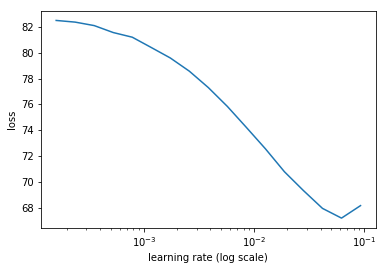

In [79]:
learn.lr_find(lrs/1000, 1.)
learn.sched.plot()

In [80]:
learn.fit(lr, n_cycle=1, cycle_len=5, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   
    0      44.753149  31.969421 
    1      35.319592  28.394699 
    2      31.110459  27.611082 
    3      28.48314   26.859531 
    4      26.73657   25.929768 



[25.929768]

In [81]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   
    0      27.15802   30.021042 
    1      26.751438  28.009958 
    2      25.598608  26.698925 
    3      24.233926  26.040436 
    4      23.00214   25.729973 



[25.729973]

In [82]:
learn.save('0')

In [83]:
learn.load('0')

## Testing

In [84]:
x, y = next(iter(md.val_dl))
#ground truth is y
x, y = V(x), V(y)


In [85]:
learn.model.eval()
#run a batch of images through the learner (ie to_gpu(nn.Sequential(*(layers+fc_layers))))
batch = learn.model(x)
#deconstuct the result, as out contained a list of the batch of bboxes and batch of classes
b_clas, b_bb = batch

In [86]:
#classes size: bs=64 x 16 grid cells x 21 classes

In [87]:
b_clas.size()

torch.Size([64, 16, 21])

In [88]:
#get 1st item in the batch
b_clasi = b_clas[0]
#each clas has 16 rows, 21 columns
#show the class values for row 0
b_clasi[0]

Variable containing:
-9.3863
-3.8717
-7.6369
-9.4372
-5.7647
-8.1774
-6.9376
-7.4082
-7.1768
-9.1514
-8.2583
-7.2349
-6.3844
-5.2353
-0.8203
-7.7559
-9.7294
-8.6840
-7.6978
-8.6625
-3.0886
[torch.cuda.FloatTensor of size 21 (GPU 0)]

In [89]:
#bbox coords bs=64 x 16 x 4 coordinates - 16 sets of coordinates of the anchor boxes?

In [90]:
#show maximum class values for each of the 16 rows in the matrix
#note how now we get get a cuda.LongTensor in addition to the FloatTensor (pyTorch max fn gives us the max and the index of the max)
#ie for each of the 16 cells, get the class
maximum_clas = b_clasi.max(1)
maximum_clas  #maximum_clas[1] returns the LongTensor index of max component

(Variable containing:
 -0.8203
 -0.8227
  0.9140
  0.5836
 -3.0390
 -3.5316
 -3.0096
 -3.1188
 -0.0927
 -0.2267
  2.6755
 -0.9754
 -2.8870
 -2.7959
 -0.7768
 -2.8505
 [torch.cuda.FloatTensor of size 16 (GPU 0)], Variable containing:
  14
  14
  14
  14
  14
  20
  20
  20
   1
   1
   1
   1
  20
  20
   1
   1
 [torch.cuda.LongTensor of size 16 (GPU 0)])

In [91]:
#for eample, get the class name for the first batch item, first cell (the cyclist seen in lesson 1)
clas_name = id2cat[to_np(maximum_clas[1])[0]]
clas_name

'person'

In [92]:
b_bb.size()

torch.Size([64, 16, 4])

In [93]:
idx=7

b_clasi = b_clas[idx]
b_bboxi = b_bb[idx]
ima=md.val_ds.ds.denorm(to_np(x))[idx]

#get ground truth bboxes and classes for the 3 objects in this image (7)
#note bbox coords scaled to b/w 0 and 1 ie relative to size of image
bbox, clas = get_y(y[0][idx], y[1][idx])
bbox, clas

(Variable containing:
  0.6786  0.4866  0.9911  0.6250
  0.7098  0.0848  0.9911  0.5491
  0.5134  0.8304  0.6696  0.9063
 [torch.cuda.FloatTensor of size 3x4 (GPU 0)], Variable containing:
   8
  10
  17
 [torch.cuda.LongTensor of size 3 (GPU 0)])

In [94]:
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    prs_val = to_np(prs) if prs is not None else None
    clas_np = to_np(clas)
    #print(f'bbox pre scaling: {bbox}')
    bbox_np = to_np((bbox*224).long())
    return show_ground_truth(ax, ima, bbox_np, clas_np, prs_val, thresh)

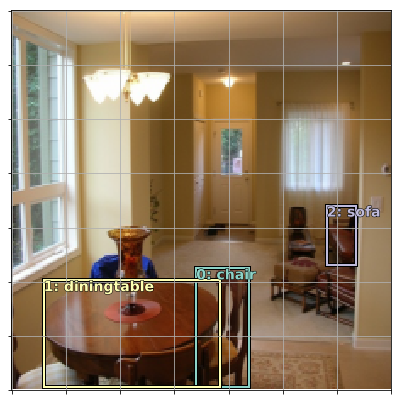

In [95]:
fig, ax = plt.subplots(figsize = (7,7))
torch_gt(ax,ima, bbox, clas)

Now show the 4 x 4 grid cells from out final conv layer

Each of these cells called differetly depending on the paper: anchor boxes, prior boxes or default boxes 

Go through each of these anchor cells and work out which one of the bounding boxes has the highest ammount of overlap with it.

Measure the overlap with Jaccard Index (Intersection/Union)

So will get a 3 x 16 matrix - for each gt obj in im 7 look at IOU for each cell

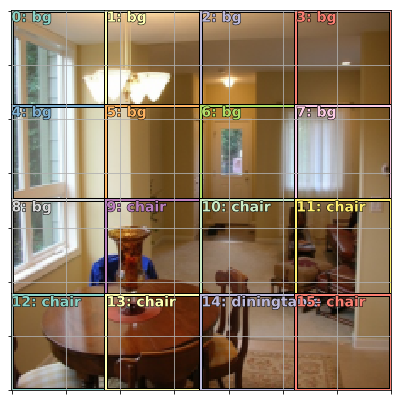

In [96]:
fig, ax = plt.subplots(figsize = (7,7))
torch_gt(ax, ima, anchor_cnr, b_clasi.max(1)[1])

In [97]:
grid_sizes

Variable containing:
 0.2500
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

In [98]:
#centre and h & w for the anchor cells
anchors

Variable containing:
 0.1250  0.1250  0.2500  0.2500
 0.1250  0.3750  0.2500  0.2500
 0.1250  0.6250  0.2500  0.2500
 0.1250  0.8750  0.2500  0.2500
 0.3750  0.1250  0.2500  0.2500
 0.3750  0.3750  0.2500  0.2500
 0.3750  0.6250  0.2500  0.2500
 0.3750  0.8750  0.2500  0.2500
 0.6250  0.1250  0.2500  0.2500
 0.6250  0.3750  0.2500  0.2500
 0.6250  0.6250  0.2500  0.2500
 0.6250  0.8750  0.2500  0.2500
 0.8750  0.1250  0.2500  0.2500
 0.8750  0.3750  0.2500  0.2500
 0.8750  0.6250  0.2500  0.2500
 0.8750  0.8750  0.2500  0.2500
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

In [99]:
a_ic = actn_to_bb(b_bboxi, anchors)

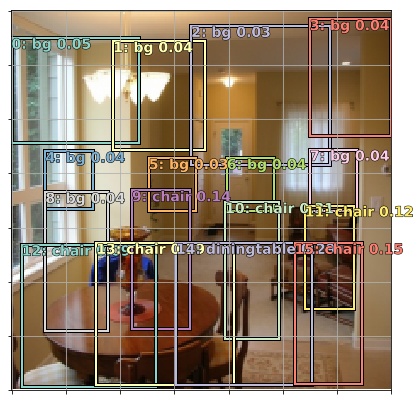

In [100]:
fig, ax = plt.subplots(figsize = (7,7))
torch_gt(ax, ima, a_ic, b_clasi.max(1)[1], b_clasi.max(1)[0].sigmoid(), thresh=0.0)

In [101]:
#3 gt objects so get a 3 x 16 overlap ammount matrix
overlaps = jaccard(bbox.data, anchor_cnr.data)
overlaps



Columns 0 to 9 
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0091
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0356  0.0549
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000

Columns 10 to 15 
 0.0922  0.0000  0.0000  0.0315  0.3985  0.0000
 0.0103  0.0000  0.2598  0.4538  0.0653  0.0000
 0.0000  0.1897  0.0000  0.0000  0.0000  0.0000
[torch.cuda.FloatTensor of size 3x16 (GPU 0)]

In [102]:
#get match of each row, for each gt obj whats the max overlap with some grid cell
#ie index 14 grid cell is largest overlap with first object
overlaps.max(1)

(
  0.3985
  0.4538
  0.1897
 [torch.cuda.FloatTensor of size 3 (GPU 0)], 
  14
  13
  11
 [torch.cuda.LongTensor of size 3 (GPU 0)])

In [103]:
#whats max overlap for each grid cell across all the gt objects
#LongTensor shows the index of the gt object that overlaps with relevant cell the most
overlaps.max(0)

(
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0356
  0.0549
  0.0922
  0.1897
  0.2598
  0.4538
  0.3985
  0.0000
 [torch.cuda.FloatTensor of size 16 (GPU 0)], 
  0
  0
  0
  0
  0
  0
  0
  0
  1
  1
  0
  2
  1
  1
  0
  0
 [torch.cuda.LongTensor of size 16 (GPU 0)])

In [104]:
#assign anchor cells to gt objects, of not a max then assign if overlap > threshold, otherwise assign background
gt_overlap, gt_idx = map_to_ground_truth(overlaps)
#see assignments in gt_idx and see where assigned bg where gt_overlap <0.5
gt_overlap, gt_idx

(
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0356
  0.0549
  0.0922
  1.9900
  0.2598
  1.9900
  1.9900
  0.0000
 [torch.cuda.FloatTensor of size 16 (GPU 0)], 
  0
  0
  0
  0
  0
  0
  0
  0
  1
  1
  0
  2
  1
  1
  0
  0
 [torch.cuda.LongTensor of size 16 (GPU 0)])

In [105]:
gt_clas = clas[gt_idx]; gt_clas

Variable containing:
  8
  8
  8
  8
  8
  8
  8
  8
 10
 10
  8
 17
 10
 10
  8
  8
[torch.cuda.LongTensor of size 16 (GPU 0)]

In [106]:
thresh = 0.5
pos = gt_overlap > thresh
pos_idx = torch.nonzero(pos)[:,0]
neg_idx = torch.nonzero(1-pos)[:,0]
#show our 3 classes that have been predicted for this image (7) 
pos_idx


 11
 13
 14
[torch.cuda.LongTensor of size 3 (GPU 0)]

In [107]:
pos


 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 1
 0
 1
 1
 0
[torch.cuda.ByteTensor of size 16 (GPU 0)]

In [108]:
gt_clas[1-pos] = len(id2cat)
#show list of what each of the anchor boxes are meant to be predicting
[id2cat[o] if o < len(id2cat) else 'bg' for o in gt_clas.data]

['bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'sofa',
 'bg',
 'diningtable',
 'chair',
 'bg']

In [109]:
gt_bbox = bbox[gt_idx]
#take activation for only those that matched: a_ic[pos_idx]
#subtract from these the ground truth bounding boxes: gt_bbox[pos_idx]
#take abs then mean and will get L1 loss
loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
#x ent for classifications
clas_loss = F.cross_entropy(b_clasi, gt_clas)
loc_loss, clas_loss

(Variable containing:
 1.00000e-02 *
   6.1897
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  0.9908
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


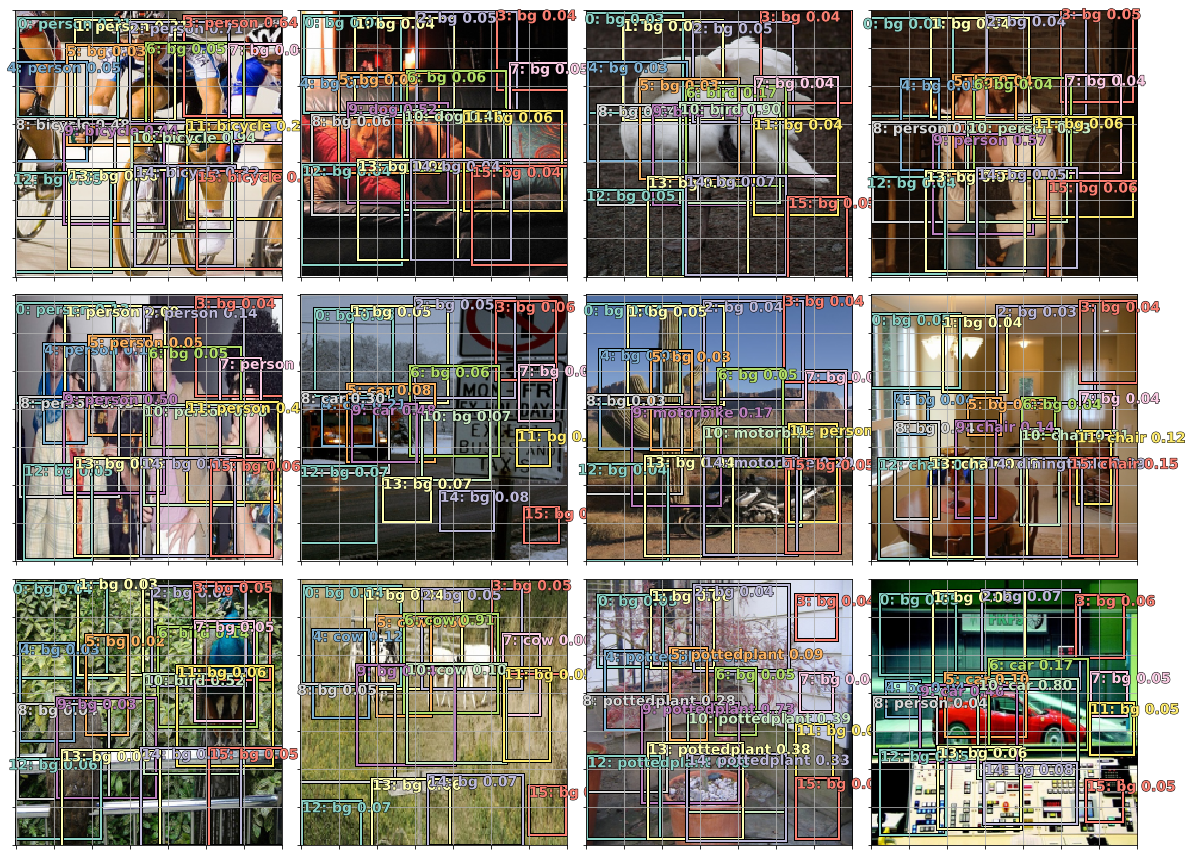

In [110]:
#output will be 16 predicted bounding boxes comming out, most will be bg
#bg box geom is meaningless
#activations: see actn_to_bb
fig, axes = plt.subplots(3, 4, figsize = (16, 12))
for idx, ax in enumerate(axes.flat):
    ima = md.val_ds.ds.denorm(to_np(x))[idx]
    bbox, clas = get_y(y[0][idx], y[1][idx])
    ima = md.val_ds.ds.denorm(to_np(x))[idx]
    bbox, clas = get_y(bbox, clas); bbox, clas
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), 0.01)
plt.tight_layout()

Results were OK but not great - not supprising as all our anchor cells were small - ie 4x4

## More Anchors

### 4.1 Create anchors

Two ways we can so this 

1. for 1x1 grid (ie if we had 2 more stride 2 convs we would get to this) we have 3x aspect ratios and 3x sizes (zooms)
2. More conv layers as sources of anchor boxes. ie as well as 4x4 we use 2x2 and 1 x 1 (whole image) grid cells. (if add 3 stride 2 convs to end we'd have 4x4, 2x2 and 1x1 grid cells all of which have anchor boxes)

So for every one of method 2, we can add the shapes and sizes from method 1

In [111]:
#define the grid cell sizes in the anchor boxes
anc_grids = [4, 2, 1]
#define the zoom levels for the anchor boxes
anc_zooms = [0.75, 1., 1.3]
#ratios
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]

anchor_scales = [(anz*i, anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]
k

9

Conv layer Filters:

4x4 conv layer already has 16 sets of activations
2x2 already has 4 sets of activations
1x1 conv layer has 1 set of activations

so we get 16 + 4 +1 activations for free

we only need to know k ie (zooms * aspect ratios), as grids we get for free through our architecture

In [112]:
#create the TL / BR corners
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

In [113]:
anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
#create middle and h/w and corners
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [114]:
#anchors

### Keys to remember:

We have a vector of ground truth bounding boxes and classes for each image from the .json file
eg [TL_x,TL_y, BR_x,BR_y, TL_x,TL_y, BR_x, BR,_y] as well as classes [person] and [dog]

Ground truth is our dependent Variable

For our NN black box:

* Take an Input 
* Generate output activations (16(4+C)) 
* Compare these to ground truth (m(4+C)) 
* Calculate loss 
* Take derivate 
* Adjust weights according to derivative x learning rate

where m is the number of ground truth objects in any particular image

Take each of the m ground truth objects and decide which set of 4+C activations is responsible for that object. 

Decide that the first 4+C activations are responsible for predicting the thing that is closest to the top left and the last 4+C activations will be resp. for pred. the furthest to BR.

Find the receptive field with max density form where the real object is - but this is a minor tweak.

SSD loss fn tasks:

1. Figure out which gt obj is closest to which anchor box (note up to now grid cell=anchor box but from here onwards we can have multiple anchor boxes per grid cell)
2. For each anchor box, decide which gt obj it is responsible for (if any).

then when have every gt object matched to an anchor box we just need to run the detn_loss() fn (see single object detection in pascal.ipynb)
ie F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

NTK - through practice:

* What are inputs and outputs to each layer in a conv network
* How big are they, what is their rank, how are they aculated
* Receptive field
* What is a loss function
* How does back prop work

Class sequence 
CV (lessons 8+9)->NLP->Stuctured data->NLP->CV (lesson 14)

Conceptually, every anchor box is associated with one set of 4+C activations in our model


In [115]:
x,y =to_np(next(iter(md.val_dl)))
x=md.val_ds.ds.denorm(x)

In [116]:
a = np.reshape((to_np(anchor_cnr) + to_np(torch.randn(*anchor_cnr.size()))*0.01)*224, -1)

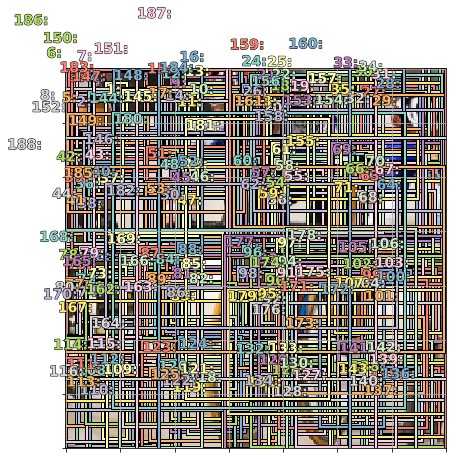

In [117]:
fig, ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, x[0], a)

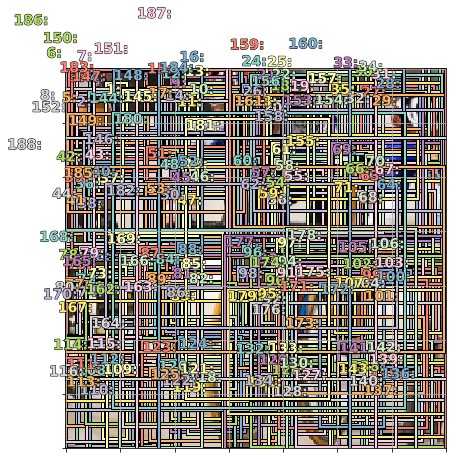

In [118]:
fig, ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, x[0], a)

In [119]:
drop = 0.4

In [120]:
class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv0 = StdConv(512, 256, stride=1, drop=drop)
        self.sconv1 = StdConv(256,256, stride=2, drop=drop) 
        self.sconv2 = StdConv(256,256, stride=2, drop=drop) 
        self.sconv3 = StdConv(256,256, stride=2, drop=drop) 
        self.out0 = OutConv(k, 256, bias)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x) #after this conv we'll get to 4x4
        #grab anchors
        o1c,o1l= self.out1(x)
        x = self.sconv2(x) #2x2
        #grab this set of outputs
        o2c,o2l= self.out2(x)
        x = self.sconv3(x) #1x1
        o3c,o3l= self.out3(x)
        #conct all these activations together so that we have one activation for every anchor box
        seq_c = torch.cat([o1c,o2c,o3c], dim=1)
        seq_l = torch.cat([o1l,o2l,o3l], dim=1)
        return [seq_c, seq_l]
        

In [121]:
head_reg4 = SSD_MultiHead(k, bias=-4.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(data=md, models=models)
learn.opt_fn = optim.Adam

In [122]:
learn.crit = ssd_loss
lr = 1e-2
lrs = np.array([lr/100,lr/10,lr])

In [123]:
x,y = next(iter(md.val_dl))
x,y = V(x), V(y)
#should we put in eval mode first?
batch = learn.model(V(x))

In [124]:
batch[0].size(), batch[1].size()

(torch.Size([64, 189, 21]), torch.Size([64, 189, 4]))

In [125]:
ssd_loss(batch, y, True)


 0.5598
 0.7922
 0.3095
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.5718
 0.7035
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.8714
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.7268
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.5163
 0.4763
 0.4033
 0.4986
 0.2990
 0.0887
 0.1046
[torch.cuda.FloatTensor of size 7 (GPU 0)]


 0.3789
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.5153
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.3985
 0.6215
 0.5547
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.4246
 0.5208
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.3436
 0.3257
 0.5062
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.9734
 0.2506
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.3900
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.7722
 0.5395
 0.6392
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.7618
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.4679
 0.8070
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.6597
 0.1274
[torch.cuda.FloatTensor of size 2 (GPU 0)]



Variable containing:
 336.2470
[torch.cuda.FloatTensor of size 1 (GPU 0)]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   
    0      369.278874 1252940.875



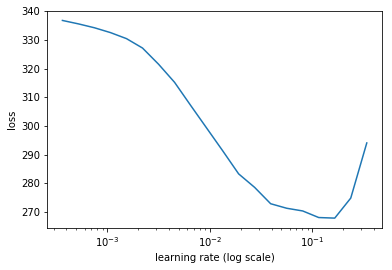

In [126]:
learn.lr_find(lrs/1000, 1.)
learn.sched.plot(n_skip_end=2)

In [127]:
learn.fit(lrs, 1, cycle_len=4, use_clr=(20,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   
    0      165.690351 138.666199
    1      132.083515 104.338898
    2      113.500291 92.053627 
    3      101.44437  87.865974 



[87.865974]

In [128]:
learn.save('tmp')

In [129]:
learn.freeze_to(-2)
learn.fit(lrs/2, 1, cycle_len=4, use_clr=(20,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   
    0      96.628378  113.953758
    1      91.336721  87.529358 
    2      84.050905  81.571884 
    3      76.348599  77.719978 



[77.71998]

In [130]:
x,y = next(iter(md.val_dl))
y = V(y)
batch = learn.model(V(x))
b_clas, b_bb = batch
x = to_np(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


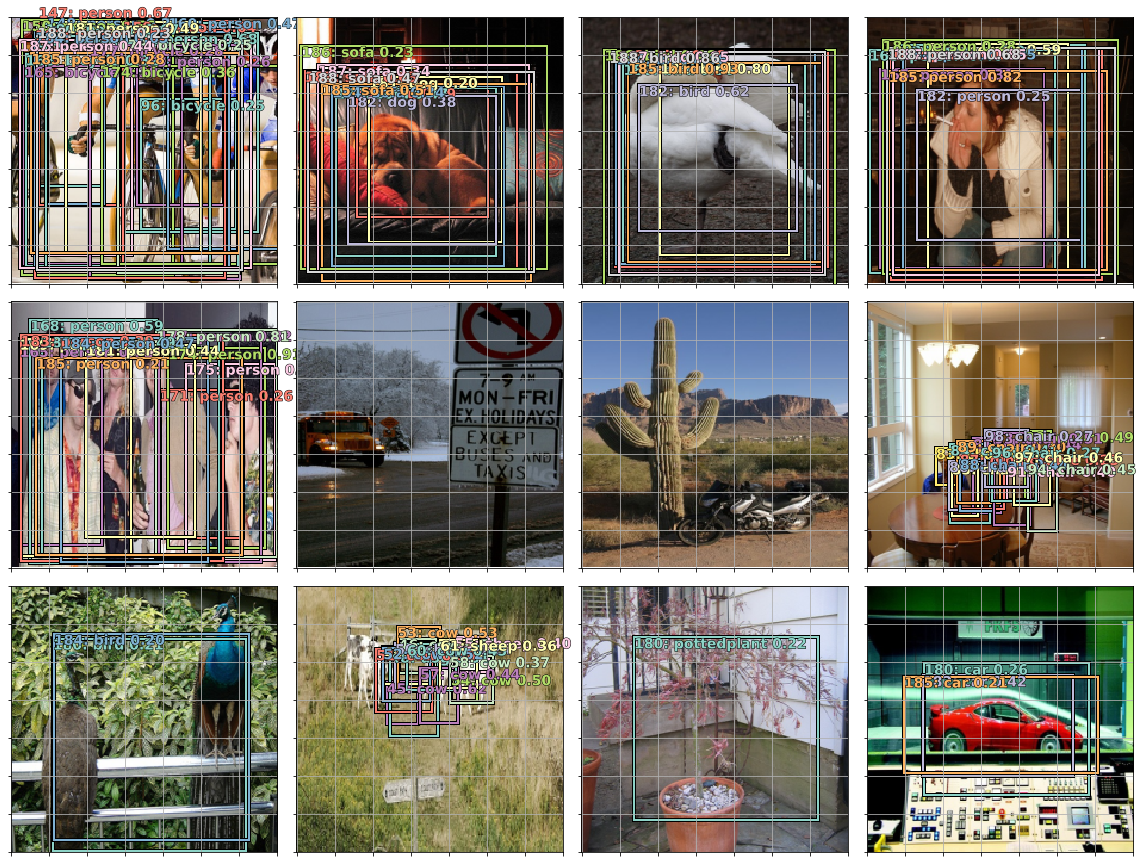

In [131]:
fig, axes = plt.subplots(3,4, figsize = (16,12))
for idx, ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(x)[idx]
    bbox,clas=get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    #those with a threshold >0.2
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), 0.2)
plt.tight_layout()

some look OK eg large items such as bird, person but motorbike has nothing
Multibox 2013 -loss fn , matching process, obj det.
R-CNN
Ross Girshick hybrid approach, replaced multibox non CV part by a convnet (1 conv, sep conv to classify first conv).
YOLO
SSD
Focal loss 2017 - see Focal Loss for Object Detection Lin et al., 2017

4 different granularities 4,2,1







## Cross-Entropy 

cross-entropy loss (log loss) penalises especially predictions that are confident and wrong

see https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html

defined by:

$$-{(y\log(p) + (1 - y)\log(1 - p))}$$

Where y is ground truth, p is predicted prob

def CrossEntropy(y, p):
    if y == 1:
      return -log(p)
    else:
      return -log(1 - p)

## Focal Loss

Focal loss - adds a factor (1-Pt)^gamma to the standard cross entropy criterion.

$$-a_t{(1-p_t)^g log(p_t))}$$
where $$p_t = p$$ if y=1 and $$p_t = 1-p $$ if otherwise

In [134]:
def plot_results(thresh):
    x,y = next(iter(md.val_dl))
    y = V(y)
    batch = learn.model(V(x))
    b_clas,b_bb = batch

    x = to_np(x)
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    for idx,ax in enumerate(axes.flat):
        ima=md.val_ds.ds.denorm(x)[idx]
        bbox,clas = get_y(y[0][idx], y[1][idx])
        a_ic = actn_to_bb(b_bb[idx], anchors)
        clas_pr, clas_ids = b_clas[idx].max(1)
        clas_pr = clas_pr.sigmoid()
        torch_gt(ax, ima, a_ic, clas_ids, clas_pr, clas_pr.max().data[0]*thresh)
    plt.tight_layout()

In [ ]:
class FocalLoss(BCE_Loss):
    #herre we override the get_weight method - which explains why it was set to None previously
    def get_weight(self,x,t):
        alpha,gamma = 0.25,2.
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

loss_f = FocalLoss(len(id2cat))